In [278]:
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix
import string
from collections import defaultdict
from tqdm import tqdm
def tokenize(document):
    return document.split()

def better_tokenize(document):
    document = (
        document.lower().translate(str.maketrans('','', string.punctuation))
        .replace("\r", " ")
        .replace("\n", " ")
        .replace("\"", "")
        .replace("\'", "")
        )
    return tokenize(document)

def create_word_counts_dict(lines, filter=0):
    word_counts = defaultdict(lambda: 0)

    for line in lines:
        tokens = better_tokenize(line)
        for token in tokens:
            word_counts[token] += 1
    return {k: v for k, v in word_counts.items() if v >= filter}

def create_term_document_matrix(file_name, include_intercept=False):
    lines = pd.read_csv(file_name)
    word_counts = create_word_counts_dict(lines["text"], filter=2)
    word_idx = {k: i for i, k in enumerate(word_counts)}
    V = len(word_counts)
    if include_intercept:
        V += 1
    D = lines.shape[0]
    X = dok_matrix((D, V), dtype=np.int64)
    for i in range(D):
        word_counts_doc = create_word_counts_dict(pd.Series(lines.iloc[i]["text"]))
        # y[i] = int(lines[i+1].strip().split(",")[-1])
        if include_intercept:
            X[i,0] = 1
        for word in word_counts_doc:
            if word in word_idx:
                j = word_idx[word]
                X[i,j] = word_counts_doc[word]
    return X, lines["sarcastic"], word_idx




X, y, word_idx = create_term_document_matrix("si630w23-hw1.train.csv", include_intercept=True)

In [350]:
class LogisticRegression():
    def __init__(self, 
                 X, 
                 y,
                 learning_rate=1e-1,
                 num_steps=100000,
                 epochs=25,
                 step_interval=50
                ):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.old_beta = np.random.rand(X.shape[1])
        self.new_beta = np.random.rand(X.shape[1])
        self.loss = []
        self.epochs = epochs
        self.step_interval=step_interval

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log_likelihood(self):
        y_hat = sigmoid(self.X @ self.new_beta.T)
        ll = np.sum(self.y * np.log(y_hat) + (1-self.y) * np.log(1-y_hat))
        return ll

    def compute_gradient(self, xi, yi):
        gradient = (yi - self.sigmoid(xi @ self.old_beta.T)) * xi
        return gradient

    def converged(self):
        if np.sum(self.old_beta) == np.sum(self.new_beta): # first iteration
            return False
        return np.allclose(self.old_beta, self.new_beta, atol=1e-1)

    def __call__(self):
        N = self.X.shape[0]
        order = np.arange(N)
        steps = 0
        epochs = 0
        while not self.converged() and epochs < self.epochs and (steps < self.num_steps):
            np.random.shuffle(order)
            for idx in tqdm(order):
                steps += 1
                xi, yi = self.X[idx], self.y[idx]
                self.new_beta = self.old_beta + (self.learning_rate * self.compute_gradient(xi, yi))
                self.old_beta = self.new_beta
                if (steps % self.step_interval == 0):
                    self.loss.append(self.log_likelihood())
            epochs += 1

    def predict(self, sentence, word_idx, include_intercept=1):
        tokens = better_tokenize(sentence)
        xi = np.zeros(X.shape[1])
        for token in tokens:
            if token in word_idx:
                xi[word_idx[token] + include_intercept] += 1
        if include_intercept:
            xi[0] = 1
        return self.sigmoid(xi @ self.new_beta.T)

In [352]:
model = LogisticRegression(X, y, num_steps=1000)
model()

100%|██████████| 3467/3467 [00:11<00:00, 308.15it/s]


Text(0.5, 1.0, 'Log Likelihood')

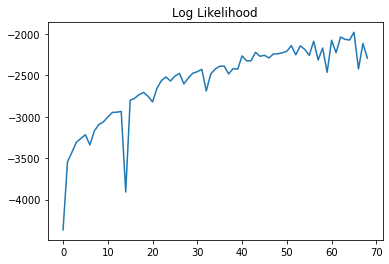

In [354]:
pd.Series(model.loss).plot().set_title("Log Likelihood")

In [ ]:
model2 = LogisticRegression(X, y)
model2()

 46%|████▌     | 1597/3467 [00:05<00:06, 305.48it/s]

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
test = pd.read_csv("si630w23-hw1.dev.csv")
y_hats = test["text"].apply(lambda s: round(model2.predict(s, word_idx, include_intercept=1)))
f1_score(list(test["sarcastic"]), list(y_hats))

In [ ]:
accuracy_score(list(test["sarcastic"]), list(y_hats))

In [ ]:
test = pd.read_csv("si630w23-hw1.test.csv")
test["prediction"] = test["text"].apply(lambda s: round(model2.predict(s, word_idx, include_intercept=1)))
test["prediction"]

In [340]:
test.to_csv("lr_submission.csv", index_label="index", columns=["prediction"])

In [341]:
!head lr_submission.csv


index,prediction
0,1
1,0
2,1
3,1
4,0
5,1
6,1
7,1
8,1
9,1
10,1
11,1
12,1
13,1
14,1
15,0
16,1
17,1
18,1
19,0
20,1
21,1
22,0
23,1
24,1
25,1
26,1
27,0
28,0
29,1
30,1
31,1
32,0
33,0
34,1
35,1
36,1
37,1
38,1
39,1
40,1
41,1
42,1
43,1
44,1
45,0
46,1
47,0
48,1
49,1
50,1
51,0
52,1
53,1
54,1
55,1
56,0
57,0
58,1
59,1
60,1
61,0
62,1
63,1
64,0
65,1
66,1
67,1
68,1
69,1
70,1
71,1
72,1
73,1
74,0
75,1
76,1
77,1
78,1
79,1
80,0
81,1
82,0
83,1
84,1
85,0
86,0
87,0
88,0
89,1
90,1
91,0
92,0
93,0
94,1
95,1
96,1
97,1
98,0
99,1
100,0
101,1
102,1
103,1
104,0
105,1
106,0
107,1
108,1
109,1
110,1
111,1
112,1
113,1
114,1
115,1
116,1
117,1
118,1
119,1
120,1
121,1
122,1
123,1
124,1
125,1
126,1
127,1
128,0
129,1
130,0
131,1
132,0
133,1
134,1
135,0
136,1
137,1
138,1
139,1
140,1
141,0
142,1
143,1
144,1
145,1
146,1
147,1
148,1
149,0
150,1
151,1
152,1
153,1
154,0
155,0
156,1
157,1
158,0
159,1
160,0
161,1
162,1
163,1
164,0
165,1
166,0
167,1
168,0
169,1
170,1
171,1
172,1
173,1
174,1
175,1
176,1
177,0
178,1
179,1
180,1
181,1
1